In [1]:
pwd = %pwd

import os, sys
sys.path.insert(0, os.path.join(pwd, "../"))

import warnings
warnings.simplefilter("ignore")

import srl

-------

# はじめに

ここでは本フレームワークでの自作アルゴリズムを作成する方法を説明します。  
構成としては大きく以下です。  

1. 概要  
1. 実装するクラスの説明  
   1. Config  
   1. RemoteMemory
   1. Parameter
   1. Trainer
   1. Worker
1. 自作アルゴリズムの登録
1. テスト
1. Q学習実装例


# 1.概要

------

自作アルゴリズムでは5つクラスを定義する必要があり、以下のように連携して動作します。

![](../diagrams/overview-sequence.drawio.png)

図では現れていませんが、5つ目としてハイパーパーパラメータを管理するConfigクラスがいます。
役割は以下です。

+ Config
  + ハイパーパラメータなどのパラメータを管理するクラス
+ Worker
  + Environmentと連携しサンプルを収集
  + 収集したサンプルをRemoteMemoryに送信
  + 行動決定に必要な情報をParameterから読む（read only）
+ Trainer
  + RemoteMemoryからサンプルを取得し学習する
  + 学習後、Parameterを更新する
+ RemoteMemory
  + サンプルを管理
+ Parameter
  + 学習パラメータを保持

分散学習は以下となり各クラスが非同期で動作します。

![](../diagrams/overview-distributed.drawio.png)

アルゴリズムを作成する視点だと大きな違いがありませんが、以下の点が異なります。  
+ WorkerがRemoteMemoryにサンプルを送るタイミングとTrainerが取り出すタイミングが異なる
+ Parameter が Worker と Trainer と同期されない
  
各クラスの実装の仕方を見ていきます。

# 2.実装するクラスの説明
-------


## 2-1.Config

強化学習アルゴリズムの種類やハイパーパラメータ等を管理するクラスです。  
基底クラスは `srl.base.rl.base.RLConfig` でこれを継承して作成します。  
  
ただ、アルゴリズムに特化したインタフェースも用意しており、  
当てはまるアルゴリズムを作成する場合はそちらを継承したほうが作成が楽になります。  
  
現状あるクラスは以下です。  

|クラス名               |説明|例|
|----------------------|---|---|
|DiscreteActionConfig  |モデルフリーでアクションが離散値のアルゴリズム|Q学習,DQN等|
|ContinuousActionConfig|モデルフリーでアクションが連続値のアルゴリズム|DDPG,SAC等|

コードは `srl.base.rl.algorithms` 配下にあります。


### RLConfig

基底クラスで定義しないといけないプロパティ・関数の説明です。

In [2]:
from dataclasses import dataclass
from srl.base.rl.base import RLConfig
from srl.base.define import RLObservationType, RLActionType

@dataclass
class MyConfig(RLConfig):
    
    # ハイパーパラメータをdataclass形式で記述すると楽です
    # (dataclassを使わなくても作成できます)

    def __post_init__(self):
        super().__init__()  # 親クラスのコンストラクタも呼び出してください

    @staticmethod
    def getName() -> str:
        """ ユニークな名前を記載 """
        raise NotImplementedError()

    @property
    def action_type(self) -> RLActionType:
        """
        アルゴリズムが想定するアクションのタイプを指定してください。
        DISCRETE  : 離散値
        CONTINUOUS: 連続値
        """
        raise NotImplementedError()

    @property
    def observation_type(self) -> RLObservationType:
        """
        アルゴリズムが想定する環境から受け取る状態のタイプを指定してください。
        DISCRETE  : 離散値
        CONTINUOUS: 連続値
        """
        raise NotImplementedError()

    # ------------------------------------
    # 以下は option です。（必須ではない）
    # ------------------------------------
    def assert_params(self) -> None:
        """ パラメータのassertを記載 """
        super().assert_params()  # 親クラスも呼び出してください


### DiscreteActionConfig

モデルフリーでアクションが離散値のアルゴリズムを想定したRLConfigです。  


In [3]:
from srl.base.rl.algorithms.discrete_action import DiscreteActionConfig

class MyConfig(DiscreteActionConfig):
    def __post_init__(self):
        super().__init__()

    @staticmethod
    def getName() -> str:
        raise NotImplementedError()

    # @property
    # def action_type(self) -> RLActionType:
    #     action_type は DISCRETE で固定です。
    #     定義する必要はありません。

    @property
    def observation_type(self) -> RLObservationType:
        raise NotImplementedError()

    # 内部的に新しく action_num が作成されます。
    # これは環境が取りうるアクションの数を返します。
    @property
    def action_num(self) -> int:
        return self._action_num


### ContinuousActionConfig

モデルフリーでアクションが連続値のアルゴリズムを想定したRLConfigです。  


In [4]:
from srl.base.rl.algorithms.continuous_action import ContinuousActionConfig
import numpy as np

class MyConfig(ContinuousActionConfig):
    def __post_init__(self):
        super().__init__()

    @staticmethod
    def getName() -> str:
        raise NotImplementedError()

    # @property
    # def action_type(self) -> RLActionType:
    #     action_type は CONTINUOUS で固定です。
    #     定義する必要はありません。

    @property
    def observation_type(self) -> RLObservationType:
        raise NotImplementedError()

    # 内部的に新しく action_num, action_low, action_high が作成されます。
    # 連続値のアクションは1次元の配列のみを想定しています。
    #   action_num : 配列数
    #   action_low : 各配列の取りうる最小値
    #   action_high: 各配列の取りうる最大値
    @property
    def action_num(self) -> int:
        return self._action_num

    @property
    def action_low(self) -> np.ndarray:
        return self._action_low

    @property
    def action_high(self) -> np.ndarray:
        return self._action_high


## 2-2.RemoteMemory

Workerが取得したサンプル(batch)をTrainerに渡す役割を持っているクラスです。  
分散学習では multiprocessing のサーバプロセス(Manager)になります。  
ですので、変数へのアクセスができなくなる点だけ制約があります。  
（全て関数経由でやり取りする必要があります）  

またよくあるクラスは `srl.rl.remote_memoty` に別途定義しており、そちらを使うこともできます。

|クラス名                 |動作|
|------------------------|---|
|SequenceRemoteMemory    |来たサンプルを順序通りに取り出します。(Queueみたいな動作です)|
|ExperienceReplayBuffer  |サンプルをランダムに取り出します。|
|PriorityExperienceReplay|サンプルを優先順位に従い取り出します。|


### RLRemoteMemory

基底クラスで定義しないといけないプロパティ・関数の説明です。

In [5]:
from srl.base.rl.base import RLRemoteMemory
from typing import cast

class MyRemoteMemory(RLRemoteMemory):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # self.config に上で定義した MyConfig が入ります
        self.config = cast(MyConfig, self.config)

    def length(self) -> int:
        """ メモリに保存されている数を返します """
        raise NotImplementedError()

    # call_restore/call_backupで復元できるように作成します
    def call_restore(self, data, **kwargs) -> None:
        self.buffer = data
    def call_backup(self, **kwargs):
        return self.buffer

    # -------
    # その他、好きな関数を定義可能です。
    # -------


### SequenceRemoteMemory

順番通りにサンプルを取り出します RemoteMemory です。  
サンプルは取り出すとなくなります。  

ハイパーパラメータは特にないので継承するだけで実装できます。


In [6]:
from srl.base.rl.remote_memory import SequenceRemoteMemory

class MyRemoteMemory(SequenceRemoteMemory):
    pass


継承すると以下の関数が追加されるのでそれを使います。

``` python
def add(self, batch: Any) -> None:
    """ サンプルを追加します """

def sample(self) -> List[Any]:
    """ バッファにたまっているサンプルを全て返し、空にします """
    return batchs
```

In [7]:
memory = SequenceRemoteMemory(None)
memory.add(1)
memory.add(2)
memory.add(3)
dat = memory.sample()
print(dat)


[1, 2, 3]


### ExperienceReplayBuffer

ランダムにサンプルを取り出すRemoteMemoryです。  
ハイパーパラメータがあるのでRLConfigの定義が追加で必要です。


In [8]:
from srl.base.rl.remote_memory import ExperienceReplayBuffer

class MyRemoteMemory(ExperienceReplayBuffer):
    def __init__(self, *args):
        super().__init__(*args)

        # init を呼び出す必要があります。
        # 引数の capacity は許容するメモリの容量です。
        self.init(self.config.capacity)


継承すると以下の関数が追加されるのでそれを使います。

``` python
def add(self, batch: Any) -> None:
    """ サンプルを追加します """

def sample(self, batch_size: int) -> List[Any]:
    """ バッファからランダムに batch_size 分のサンプルを返します """
    return batchs

def clear(self) -> None:
    """ バッファを空にします """

```

In [9]:
memory = ExperienceReplayBuffer(None)
memory.init(100)
memory.add(1)
memory.add(2)
memory.add(3)
memory.add(4)
dat = memory.sample(2)
print(dat)


[3, 1]


### PriorityExperienceReplay

優先順位に従ってサンプルを取り出すRemoteMemoryです。  
ハイパーパラメータがあるのでRLConfigの定義が追加で必要です。  
  
ハイパーパラメータは5つで、最初のnameにより挙動が変わります。  

|name              |内容|
|------------------|---|
|ReplayMemory      |ExperienceReplayBufferと同じ挙動で、ランダムに取り出します。|
|ProportionalMemory|優先度に比例して確率で選ばれます。|
|RankBaseMemory    |優先度の順位に比例して確率で選ばれます。|

|ハイパーパラメータ|内容|備考|
|------------|--------|---|
|capacity    |最大容量 ||
|alpha       |確率反映率|0.0～1.0|
|beta_initial|IS反映率の初期値|0.0～1.0|
|beta_steps  |ISの反映率を1.0にするまでのstep数||


In [10]:
from srl.base.rl.remote_memory import PriorityExperienceReplay

class RemoteMemory(PriorityExperienceReplay):
    def __init__(self, *args):
        super().__init__(*args)
        
        self.init(
            self.config.memory_name,
            self.config.capacity,
            self.config.memory_alpha,
            self.config.memory_beta_initial,
            self.config.memory_beta_steps,
        )


継承すると以下の関数が追加されるのでそれを使います。

``` python
def add(self, batch: Any, td_error: Optional[float] = None):
    """ td_error(priority)のサンプルを追加します """

def sample(self, step: int, batch_size: int) -> Tuple[list, list, list]:
    """ 優先度に従い batch_size 分のサンプルを返します """
    return indices, batchs, weights

def update(self, indices: List[int], batchs: List[Any], td_errors: np.ndarray):
    """ サンプルの優先度を td_error(priority) で更新します。 """
```

In [11]:
memory = PriorityExperienceReplay(None)
memory.init("ProportionalMemory", 100, 1.0, 1.0, 1)
memory.add(1, 1)
memory.add(2, 2)
memory.add(3, 3)
memory.add(4, 4)
indices, batchs, weights = memory.sample(1, 2)
print(batchs)
memory.update(indices, batchs, [5, 10])


[4, 3]


## 2-3.Parameter

パラメータを管理するクラスです。  
実装が必要な関数は以下です。


In [12]:
from srl.base.rl.base import RLParameter

import numpy as np

class MyParameter(RLParameter):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # self.config に上で定義した MyConfig が入ります
        self.config = cast(MyConfig, self.config)

    # call_restore/call_backupでパラメータが復元できるように作成
    def call_restore(self, data, **kwargs) -> None:
        raise NotImplementedError()
    def call_backup(self, **kwargs):
        raise NotImplementedError()

    # その他任意の関数を作成できます
    # （パラメータに関するTrainer/Workerで共通する処理など）


## 2-4.Trainer

学習を定義する部分です。  
RemoteMemory から経験を受け取ってParameterを更新します。  

実装が必要な関数は以下です。


In [13]:
from srl.base.rl.base import RLTrainer

class MyTrainer(RLTrainer):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # config,parameter,memory がそれぞれ入ります。
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

    def get_train_count(self) -> int:
        """ 学習回数を返します """
        raise NotImplementedError()

    # (abstractmethod)
    def train(self) -> dict:
        """
        RemoteMemory からbatchを受け取ってParameterを更新する形で学習を定義します。
        戻り値は任意で、学習情報を辞書形式で返します。
        """
        raise NotImplementedError()


## 2-5.Worker

実際に環境と連携して経験を収集するクラスです。  
役割は、Parameterを参照してアクションを決める事と、サンプルをRemoteMemoryに送信する事です。  
  
RLWorkerとRLTrainerのフローをすごく簡単に書くと以下です。  

``` python
env.reset()
worker.on_reset()
while:
    action = worker.policy()
    env.step(action)
    worker.on_step()
    trainer.train()
env.close()
```

RLWorkerはアルゴリズムに合わせたインタフェースのクラスを用意しています。  
そちらを継承して実装してください。  
現状あるクラスは以下です。  

|クラス名               |説明|例|
|----------------------|---|---|
|DiscreteActionWorker  |モデルフリーでアクションが離散値のアルゴリズム|Q学習,DQN等|
|ContinuousActionWorker|モデルフリーでアクションが離散値のアルゴリズム|DDPG,SAC等|
|ModelBaseWorker       |上記以外のアルゴリズム||

コードは `srl.base.rl.algorithms` 配下にあります。


### DiscreteActionWorker

DiscreteActionWorkerで実装が必要な関数は以下です。


In [14]:
from typing import List, Tuple
from srl.base.rl.algorithms.discrete_action import DiscreteActionWorker
from srl.base.define import Info

class MyWorker(DiscreteActionWorker):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # config,parameter,memory がそれぞれ入ります。
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

    def call_on_reset(self, state: np.ndarray, invalid_actions: List[int]) -> Info:
        """ エピソードの最初に呼ばれる関数

        Args:
            state (np.ndarray): 環境の初期状態
            invalid_actions (List[int]): 初期状態での有効でないアクションのリスト
        
        Returns:
            Info: 任意の情報
        """
        raise NotImplementedError()

    def call_policy(self, state: np.ndarray, invalid_actions: List[int]) -> Tuple[int, Info]:
        """ このターンで実行するアクションを返す関数

        Args:
            state (np.ndarray): 現在の状態
            invalid_actions (List[int]): 現在の有効でないアクションのリスト

        Returns: (
            int : 実行するアクション
            Info: 任意の情報
        )
        """
        raise NotImplementedError()

    def call_on_step(
        self,
        next_state: np.ndarray,
        reward: float,
        done: bool,
        next_invalid_actions: List[int],
    ) -> dict:
        """ Envが1step実行した後に呼ばれる関数

        Args:
            next_state (np.ndarray): アクション実行後の状態
            reward (float): アクション実行後の報酬
            done (bool): アクション実行後の終了状態
            next_invalid_actions (List[int]): アクション実行後の有効でないアクションのリスト

        Returns:
            dict: 情報(任意)
        """
        raise NotImplementedError()


### ContinuousActionWorker

ContinuousActionWorkerで実装が必要な関数は以下です。


In [15]:
from srl.base.rl.algorithms.continuous_action import ContinuousActionWorker

class MyWorker(ContinuousActionWorker):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # config,parameter,memory がそれぞれ入ります。
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

    def call_on_reset(self, state: np.ndarray) -> Info:
        """ エピソードの最初に呼ばれる関数

        Args:
            state (np.ndarray): 環境の初期状態
        
        Returns:
            Info: 任意の情報
        """
        raise NotImplementedError()

    def call_policy(self, state: np.ndarray) -> Tuple[List[float], Info]:
        """ このターンで実行するアクションを返す関数

        Args:
            state (np.ndarray): 現在の状態

        Returns: (
            List[float]: 実行するアクション(小数の配列)
            Info       : 任意の情報
        )
        """
        raise NotImplementedError()

    def call_on_step(self, next_state: np.ndarray, reward: float, done: bool) -> dict:
        """ Envが1step実行した後に呼ばれる関数

        Args:
            next_state (np.ndarray): アクション実行後の状態
            reward (float): アクション実行後の報酬
            done (bool): アクション実行後の終了状態

        Returns:
            dict: 情報(任意)
        """
        raise NotImplementedError()


### ModelBaseWorker

ModelBaseWorker は実行時のクラスである EnvRun、WorkerRun を直接操作して実装するクラスです。  
（直接環境を操作できます）  
出来ることが多いのと、仕様が変わる可能性大きいので詳細は一旦保留します。(TODO)

実装が必要な関数は以下です。


In [16]:
from srl.base.rl.algorithms.modelbase import ModelBaseWorker

from srl.base.define import Info, RLAction, RLObservation
from srl.base.env.base import EnvRun
from srl.base.rl.worker import RLWorker, WorkerRun

class MyWorker(ModelBaseWorker):
    def __init__(self, *args):
        """ コントラクタの引数は親に渡してください """
        super().__init__(*args)

        # config,parameter,memory がそれぞれ入ります。
        self.config = cast(MyConfig, self.config)
        self.parameter = cast(MyParameter, self.parameter)
        self.remote_memory = cast(MyRemoteMemory, self.remote_memory)

    def call_on_reset(self, state: RLObservation, env: EnvRun, worker: WorkerRun) -> Info:
        """ エピソードの最初に呼ばれる関数

        Args:
            state (np.ndarray): 環境の初期状態
            env: EnvRun
            worker: WorkerRun
          
        Returns:
            Info: 任意の情報
        """
        raise NotImplementedError()

    def call_policy(self, state: RLObservation, env: EnvRun, worker: WorkerRun) -> Tuple[RLAction, Info]:
        """ このターンで実行するアクションを返す関数

        Args:
            state (np.ndarray): 現在の状態
            env: EnvRun
            worker: WorkerRun

        Returns: (
            RLAction: 実行するアクション
            Info    : 任意の情報
        )
        """
        raise NotImplementedError()

    def call_on_step(
        self,
        next_state: RLObservation,
        reward: float,
        done: bool,
        env: EnvRun,
        worker: WorkerRun,
    ) -> dict:
        """ Envが1step実行した後に呼ばれる関数

        Args:
            next_state (np.ndarray): アクション実行後の状態
            reward (float): アクション実行後の報酬
            done (bool): アクション実行後の終了状態
            env: EnvRun
            worker: WorkerRun

        Returns:
            dict: 情報(任意)
        """
        raise NotImplementedError()


### Worker共通の操作

Workerで共通して持っているプロパティ・関数は以下となります。


In [17]:
from typing import Optional
from srl.base.define import RLAction

class _RLWorker:
    @property
    def training(self) -> bool:
        """ trainig かどうかを返します """
        return self._training

    @property
    def distributed(self) -> bool:
        """ 分散実行中かどうかを返します """
        return self._distributed

    def render_terminal(self, env, worker, **kwargs) -> None:
        """ 
        描画用の関数です。
        実装するとrenderによる描画が可能になります。
        """
        pass

    def render_rgb_array(self, env, worker, **kwargs) -> Optional[np.ndarray]:
        """ 
        描画用の関数です。
        実装するとrenderによる描画が可能になります。
        """
        return None

    @property
    def player_index(self) -> int:
        """ 複数人実行する環境にて、自分のプレイヤー番号を返します """
        return self._player_index

    def get_invalid_actions(self, env=None) -> List[RLAction]:
        """ 有効でないアクションを返します(離散限定) """
        return invalid_actions
    
    def get_valid_actions(self, env=None) -> List[RLAction]:
        """ 有効なアクションを返します(離散限定) """
        return valid_actions
    
    def sample_action(self, env=None) -> RLAction:
        """ ランダムなアクションを返します """
        return action


# 3.自作アルゴリズムの登録

以下で登録します。  
第2引数以降の entry_point は、`モジュールパス + ":" + クラス名`で、  
モジュールパスは `importlib.import_module` で呼び出せる形式である必要があります。

``` python
from srl.base.rl.registration import register
register(
    MyConfig,
    __name__ + ":MyRemoteMemory",
    __name__ + ":MyParameter",
    __name__ + ":MyTrainer",
    __name__ + ":MyWorker",
)
```

# 4.実装例(Q学習)

In [18]:
import json
import random
from dataclasses import dataclass
from typing import List, cast

import numpy as np
from srl.base.define import RLObservationType
from srl.base.rl.algorithms.discrete_action import DiscreteActionConfig, DiscreteActionWorker
from srl.base.rl.base import RLParameter, RLTrainer
from srl.base.rl.registration import register
from srl.base.rl.remote_memory import SequenceRemoteMemory


@dataclass
class Config(DiscreteActionConfig):

    epsilon: float = 0.1
    test_epsilon: float = 0
    gamma: float = 0.9
    lr: float = 0.1

    def __post_init__(self):
        super().__init__()

    @property
    def observation_type(self) -> RLObservationType:
        return RLObservationType.DISCRETE

    @staticmethod
    def getName() -> str:
        return "MyRL"


class RemoteMemory(SequenceRemoteMemory):
    pass


class Parameter(RLParameter):
    def __init__(self, *args):
        super().__init__(*args)
        self.config = cast(Config, self.config)

        self.Q = {}  # Q学習用のテーブル

    def call_restore(self, data, **kwargs) -> None:
        self.Q = json.loads(data)

    def call_backup(self, **kwargs):
        return json.dumps(self.Q)

    # Q値を取得する関数
    def get_action_values(self, state: str):
        if state not in self.Q:
            self.Q[state] = [0] * self.config.action_num
        return self.Q[state]


class Trainer(RLTrainer):
    def __init__(self, *args):
        super().__init__(*args)
        self.config = cast(Config, self.config)
        self.parameter = cast(Parameter, self.parameter)
        self.remote_memory = cast(RemoteMemory, self.remote_memory)

        self.train_count = 0

    def get_train_count(self):
        return self.train_count

    def train(self):

        # memoryから経験を取得する
        batchs = self.remote_memory.sample()
        td_error = 0
        for batch in batchs:
            # 各batch毎にQテーブルを更新する
            s = batch["state"]
            n_s = batch["next_state"]
            action = batch["action"]
            reward = batch["reward"]
            done = batch["done"]

            q = self.parameter.get_action_values(s)
            n_q = self.parameter.get_action_values(n_s)

            if done:
                target_q = reward
            else:
                target_q = reward + self.config.gamma * max(n_q)

            td_error = target_q - q[action]
            q[action] += self.config.lr * td_error

            td_error += td_error
            self.train_count += 1

        if len(batchs) > 0:
            td_error /= len(batchs)

        # 学習結果の情報を返す(任意)
        return {
            "Q": len(self.parameter.Q),
            "td_error": td_error,
        }


class Worker(DiscreteActionWorker):
    def __init__(self, *args):
        super().__init__(*args)
        self.config = cast(Config, self.config)
        self.parameter = cast(Parameter, self.parameter)
        self.remote_memory = cast(RemoteMemory, self.remote_memory)

    def call_on_reset(self, state: np.ndarray, invalid_actions: List[int]) -> dict:
        return {}

    def call_policy(self, state: np.ndarray, invalid_actions: List[int]) -> Tuple[int, dict]:
        self.state = str(state.tolist())

        # 学習中かどうかで探索率を変える
        if self.training:
            epsilon = self.config.epsilon
        else:
            epsilon = self.config.test_epsilon

        if random.random() < epsilon:
            # epsilonより低いならランダムに移動
            self.action = self.sample_action()
        else:
            q = self.parameter.get_action_values(self.state)
            q = np.asarray(q)

            # 最大値を選ぶ（複数あればランダム）
            self.action = random.choice(np.where(q == q.max())[0])

        return self.action, {}

    def call_on_step(
        self,
        next_state: np.ndarray,
        reward: float,
        done: bool,
        next_invalid_actions: List[int],
    ) -> dict:
        if not self.training:
            return {}

        batch = {
            "state": self.state,
            "next_state": str(next_state.tolist()),
            "action": self.action,
            "reward": reward,
            "done": done,
        }
        self.remote_memory.add(batch)
        return {}

    # 強化学習の可視化用、今回ですとQテーブルを表示しています。
    def render_terminal(self, env, worker, **kwargs) -> None:
        q = self.parameter.get_action_values(self.state)
        maxa = np.argmax(q)
        for a in range(self.config.action_num):
            if a == maxa:
                s = "*"
            else:
                s = " "
            s += f"{env.action_to_str(a)}: {q[a]:7.5f}"
            print(s)

register(
    Config,
    __name__ + ":RemoteMemory",
    __name__ + ":Parameter",
    __name__ + ":Trainer",
    __name__ + ":Worker",
)


# 5.テスト

最低限ですが、ちゃんと動くか以下でテストできます。


pygame 2.1.2 (SDL 2.0.18, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
--- Grid raw check start ---
--- Grid sequence check start ---
### env: Grid, rl: MyRL, max episodes: -1, timeout:  -1.00s, max steps: 10, max train: -1
12:54:53   0.00s( -0.00s left)     11st(   0ep)    10tr,    11 step, 0.00000s/step, 0.00000s/tr,       0 mem(41.0% PC)|Q 2.909|td_error -0.071
### 0, action -, rewards[0.000,], next 0
env   {}
work0 None
......
.   G.
. . X.
.P   .
......


### 1, action 2(→), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.   G.
. . X.
. P  .
......


 ←: -0.00760
*↓: 0.00000
 →: 0.00000
 ↑: -0.00400

### 2, action 0(←), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.   G.
. . X.
.P   .
......


 ←: -0.00760
*↓: 0.00000
 →: 0.00000
 ↑: -0.00400

### 3, action 1(↓), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.   G.
. . X.
.P   .
......


 ←: -0.00760
*↓: 0.00000
 →: 0.00000
 ↑: -0.00400

### 4, action 2(→),

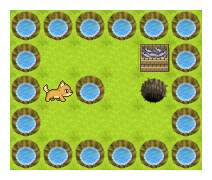

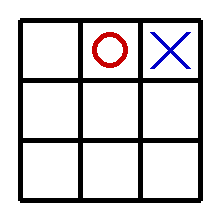

In [19]:
from srl.test import TestRL

tester = TestRL()
tester.simple_check(Config())
#if __name__ == '__main__':
#    tester.simple_check_mp(Config()) # notebook で実行できないバグあり


# 6.Grid環境の学習

### env: Grid, rl: MyRL, max episodes: 10000, timeout:  -1.00s, max steps: -1, max train: -1
12:54:59   5.00s(  2.04s left)  49922st(6606ep) 49921tr, -2.4 0.682 0.8 re(0.731 eval), 7.6 step, 0.00s/ep, 0.000s/tr,       0 mem(41.0% PC)|Q 10.998|td_error 0.001
12:55:02   7.49s(  0.00s left)  75502st(10000ep) 75502tr, -2.1 0.689 0.8 re(0.739 eval), 7.5 step, 0.00s/ep, 0.000s/tr,       0 mem(40.9% PC)|Q 11.000|td_error -0.002


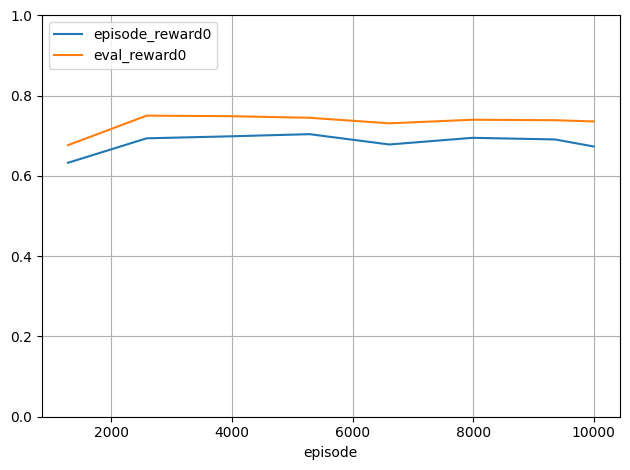

100エピソードの平均結果 0.7248000052571296


In [20]:
import srl
from srl import runner
from srl.envs import grid

config = runner.Config(
    env_config=srl.EnvConfig("Grid"),
    rl_config=Config(),
)

# --- train
parameter, remote_memory, history = runner.train(config, max_episodes=10000)
history.plot(left_ymin=0, left_ymax=1)

# --- test
rewards = runner.evaluate(config, parameter, max_episodes=100)
print("100エピソードの平均結果", np.mean(rewards))


In [21]:
reward, render = runner.render(config, parameter, enable_animation=True)


### 0, action -, rewards[0.000,], next 0
env   {}
work0 None
......
.   G.
. . X.
.P   .
......


### 1, action 3(↑), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.   G.
.P. X.
.    .
......


 ←: 0.28244
 ↓: 0.28420
 →: 0.22188
*↑: 0.34296

### 2, action 3(↑), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.P  G.
. . X.
.    .
......


 ←: 0.28244
 ↓: 0.28420
 →: 0.22188
*↑: 0.34296

### 3, action 2(→), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
. P G.
. . X.
.    .
......


 ←: 0.28244
 ↓: 0.28420
 →: 0.22188
*↑: 0.34296

### 4, action 2(→), rewards[-0.040,], next 0 (0.0s)
env   {}
work0 {}
......
.  PG.
. . X.
.    .
......


 ←: 0.28244
 ↓: 0.28420
 →: 0.22188
*↑: 0.34296

### 5, action 2(→), rewards[1.000,], done(env), next 0 (0.0s)
env   {}
work0 {}
......
.   P.
. . X.
.    .
......




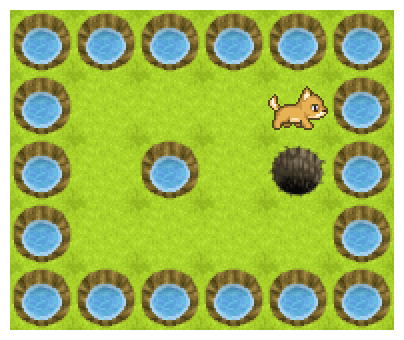

In [22]:
# render.create_anime(scale=2).save("MyRL-Grid.gif")
render.display(scale=2)
